# Analysis of network growth

## Load data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt, matplotlib as mpl
import numpy as np
import igraph as ig
import random
from tqdm import tqdm
import statsmodels.formula.api as smf

In [2]:
df_edges: pd.DataFrame = pd.read_pickle('../data/generated/graph/actor_graph_full.ungrouped.pkl')
df_movies: pd.DataFrame = pd.read_pickle('../data/generated/preprocessed/movies.pkl')

# TODO : move this to preprocess
df_movies['movie_release'] = pd.to_datetime(df_movies.movie_release, yearfirst=True)

## Prepare temporal graphs edges

In [3]:
df_edges['movie_release_year'] = df_movies.set_index('fb_id').loc[df_edges.movie_fbid].movie_release_year.values
df_edges.sort_values('movie_release_year', inplace=True)

# we drop the movies release outside our period of study

print(f'length before purge : {len(df_edges)}')
df_edges.dropna(subset='movie_release_year', inplace=True)  # some movies do not have dates associated to them
# df_edges.drop(index=df_edges[((df_edges.movie_release_year <= min(years_bins)) | (df_edges.movie_release_year > max(years_bins)))].index, inplace=True)
# df_edges.drop(index=df_edges[(df_edges.movie_release_year > 2015)].index, inplace=True)
print(f'length after purge : {len(df_edges)}')

# assert min(years_bins) < df_edges.movie_release_year.min()
# assert df_edges.movie_release_year.max() <= max(years_bins)

df_edges

length before purge : 2241657
length after purge : 2224839


,actor1_fbid,actor2_fbid,movie_fbid,movie_release_year
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888
678021,/m/0k2pz6,/m/0k2pzd,/m/044ggd,1888
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888
...,...,...,...,...
1118304,/m/0fdc74,/m/0g7dfl,/m/064mmw7,2016
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016
1118293,/m/0736qr,/m/0d0plm,/m/064mmw7,2016


In [4]:
years = df_edges.movie_release_year.unique().astype(int)

## Model growth

We consider the initial actor network at the year 1900

https://barabasi.com/f/622.pdf

Is there preferential attachment ?

The preferential attachment $\Pi(k_i) = \frac{k_i}{\sum_j k_j}$ can be empirically estimated through $\Pi(k_i) \sim \Delta k_i$. We plot it for each node, and for every year.

We use a log scale, since we expect preferential attachment to behave as a power law, $\Pi(k) \sim k^{\alpha}$. Note that this also deals with the problem of dead actors present in the data. Since for dead actors $\Delta k_i = 0$, the log scale crops out these datapoints

<img src="../assets/Screenshot from 2022-12-13 20-43-30.png">
<br>
<img src="../assets/Screenshot from 2022-12-13 20-43-41.png">

### Numerical indices

We use numerical indices instead of freebase ids, in order to index into numpy arrays later

In [5]:
codes, uniques = pd.factorize(pd.concat([df_edges.actor1_fbid, df_edges.actor2_fbid]))
df_edges['actor1_numid'] = codes[:len(df_edges)]
df_edges['actor2_numid'] = codes[len(df_edges):]
df_edges

,actor1_fbid,actor2_fbid,movie_fbid,movie_release_year,actor1_numid,actor2_numid
678019,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888,0,1
678021,/m/0k2pz6,/m/0k2pzd,/m/044ggd,1888,1,119615
678017,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888,2,1
678016,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888,2,0
678020,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888,0,119615
...,...,...,...,...,...,...
1118304,/m/0fdc74,/m/0g7dfl,/m/064mmw7,2016,79054,73797
1118305,/m/06k6ns,/m/0fqwzd,/m/064mmw7,2016,61062,52861
1118306,/m/06k6ns,/m/0fdc74,/m/064mmw7,2016,61062,79054
1118293,/m/0736qr,/m/0d0plm,/m/064mmw7,2016,41486,51342


In [6]:
print(f'total {uniques.nunique()} nodes (actors)')

total 134649 nodes (actors)


### Compute degree evolution

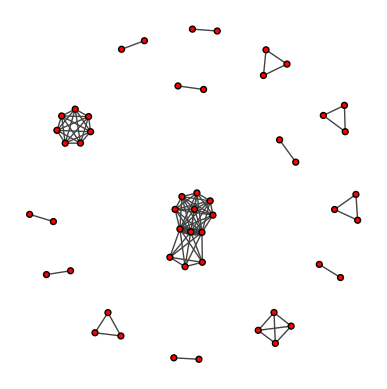

In [7]:
def get_edges_year(year: int) -> pd.DataFrame:
	"""Return weighted edges for all movies released before and on ``year``"""
	return (df_edges
		.query(f'movie_release_year <= {year}')
		.groupby(['actor1_numid', 'actor2_numid'])
		[['movie_fbid']]
		.nunique()
		.reset_index()
		.rename(columns={'movie_fbid': 'movie_count'})
	)

# test the function
random.seed(0)  # seed the random layout
fig, ax = plt.subplots()
g0 = ig.Graph.DataFrame(get_edges_year(years[10])[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
ig.plot(g0, target=ax,
	# vertex_label=g0.vs['name'], vertex_label_size=7,
	edge_width=g0.es['movie_count']
);

#### Run computation

Note : actors keep their degree even after they die !

In [8]:
if False:  # recompute
	degrees = np.zeros((uniques.nunique(), df_edges.movie_release_year.nunique()))

	for iyear, year in tqdm(enumerate(years), total=len(years)):
		g = ig.Graph.DataFrame(get_edges_year(year)[['actor1_numid', 'actor2_numid', 'movie_count']], directed=False, use_vids=False)
		# print(g.summary())
		for node, k in zip(g.vs, g.degree()):
			degrees[node['name'], iyear] = k
	
	np.savez('../data/generated/graph/actor_graph_full_degrees.npz', degrees)

else:  # load from precomputed
	degrees = np.load('../data/generated/graph/actor_graph_full_degrees.npz')['arr_0']

In [9]:
delta_degrees = np.diff(degrees, axis=-1)

In [10]:
# k = 0 corresponds to actors not yet born
degrees[degrees == 0] = np.nan
# Delta k = 0 corresponds to actors that don't evolve
delta_degrees[delta_degrees == 0] = np.nan

In [11]:
# convert the data to a dataframe
df_degree = pd.DataFrame(degrees, columns=years).melt(var_name='year', value_name='degree', ignore_index=False)
df_degree.dropna(inplace=True)
df_degree.reset_index(inplace=True, names='actor_numid')

df_delta_degree = pd.DataFrame(delta_degrees, columns=years[:-1]).melt(var_name='year', value_name='delta_degree', ignore_index=False)
df_delta_degree.dropna(inplace=True)
df_delta_degree.reset_index(inplace=True, names='actor_numid')

df_pref_attachment = pd.merge(df_delta_degree, df_degree, how='inner', on=['actor_numid', 'year'])

In [12]:
df_pref_attachment

,actor_numid,year,delta_degree,degree
0,7,1898,4.0,1.0
1,12,1898,4.0,1.0
2,7,1901,6.0,5.0
3,11,1901,6.0,5.0
4,12,1901,6.0,5.0
...,...,...,...,...
195683,51342,2015,1.0,149.0
195684,52861,2015,4.0,57.0
195685,61062,2015,1.0,114.0
195686,73797,2015,1.0,51.0


### Degree evolution

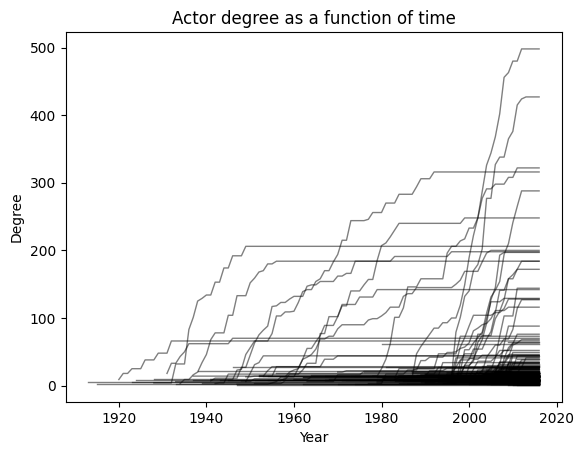

In [13]:
fig, ax = plt.subplots()
np.random.seed(0)
# we plot only 256 actors because plotting all 1.3M of them would take ages !!
ax.plot(years, degrees[np.random.randint(0, len(degrees), 256)].T, color='black', alpha=0.5, linewidth=1)
ax.set_xlabel('Year')
ax.set_ylabel('Degree')
ax.set_title('Actor degree as a function of time')
plt.show()

The degree seems to grow linearly in time, but faster when actors enter late into the graph !

### Preferential attachment

We fit $\Pi(k) \sim \Delta k \sim k^{\alpha}$, so that $\log \Pi(k) = \alpha \log k + (b + \text{normalization constant})$

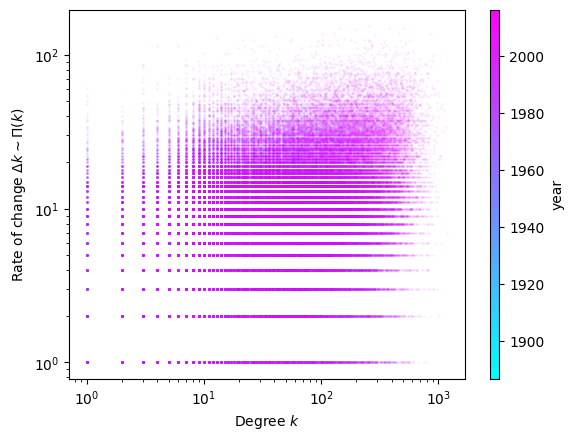

In [14]:
fig, ax = plt.subplots()

cmap = mpl.cm.get_cmap('cool')(np.linspace(0, 1, len(years)))
cax, kw = mpl.colorbar.make_axes(ax, pad=0.05, aspect=40)
cb = mpl.colorbar.ColorbarBase(cax, cmap='cool', values=years, label='year')
yearcolor = { year: color for year, color in zip(years, cmap) }

for iyear, year in enumerate(years[:-1]):
	ax.plot(degrees[:, iyear], delta_degrees[:, iyear], 'o', color=yearcolor[year], alpha=0.05, markersize=1)

ax.set_xlabel('Degree $k$')
ax.set_ylabel('Rate of change $\\Delta k \\sim \Pi(k)$')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

# difficult to see anything... let's do binning on years !

In [15]:
# df_pref_attachment['year_bin'] = pd.qcut(df_pref_attachment.year, q=10, precision=0)
df_pref_attachment['year_bin'] = pd.cut(df_pref_attachment.year, range(1890, 2010+1, 10), precision=0)
df_pref_attachment['year_qbin'] = pd.qcut(df_pref_attachment.year, q=12, precision=0)

In [16]:
# check how many samples we have per bin
# few samples especially in the beginning ! this will be reflected in the CI
df_pref_attachment.groupby('year_bin')[['degree']].count()

,degree
year_bin,
"(1890, 1900]",2
"(1900, 1910]",43
"(1910, 1920]",1315
"(1920, 1930]",3903
"(1930, 1940]",8992
"(1940, 1950]",10043
"(1950, 1960]",12744
"(1960, 1970]",14597
"(1970, 1980]",17597


In [17]:
# qcut yields more even results.. but less fine-grained at the start
df_pref_attachment.groupby('year_qbin')[['degree']].count()

,degree
year_qbin,
"(1897.0, 1943.0]",17142
"(1943.0, 1957.0]",16029
"(1957.0, 1969.0]",16826
"(1969.0, 1978.0]",15335
"(1978.0, 1986.0]",16826
"(1986.0, 1992.0]",15696
"(1992.0, 1997.0]",16729
"(1997.0, 2001.0]",17793
"(2001.0, 2004.0]",16889


Grouping by year_bin


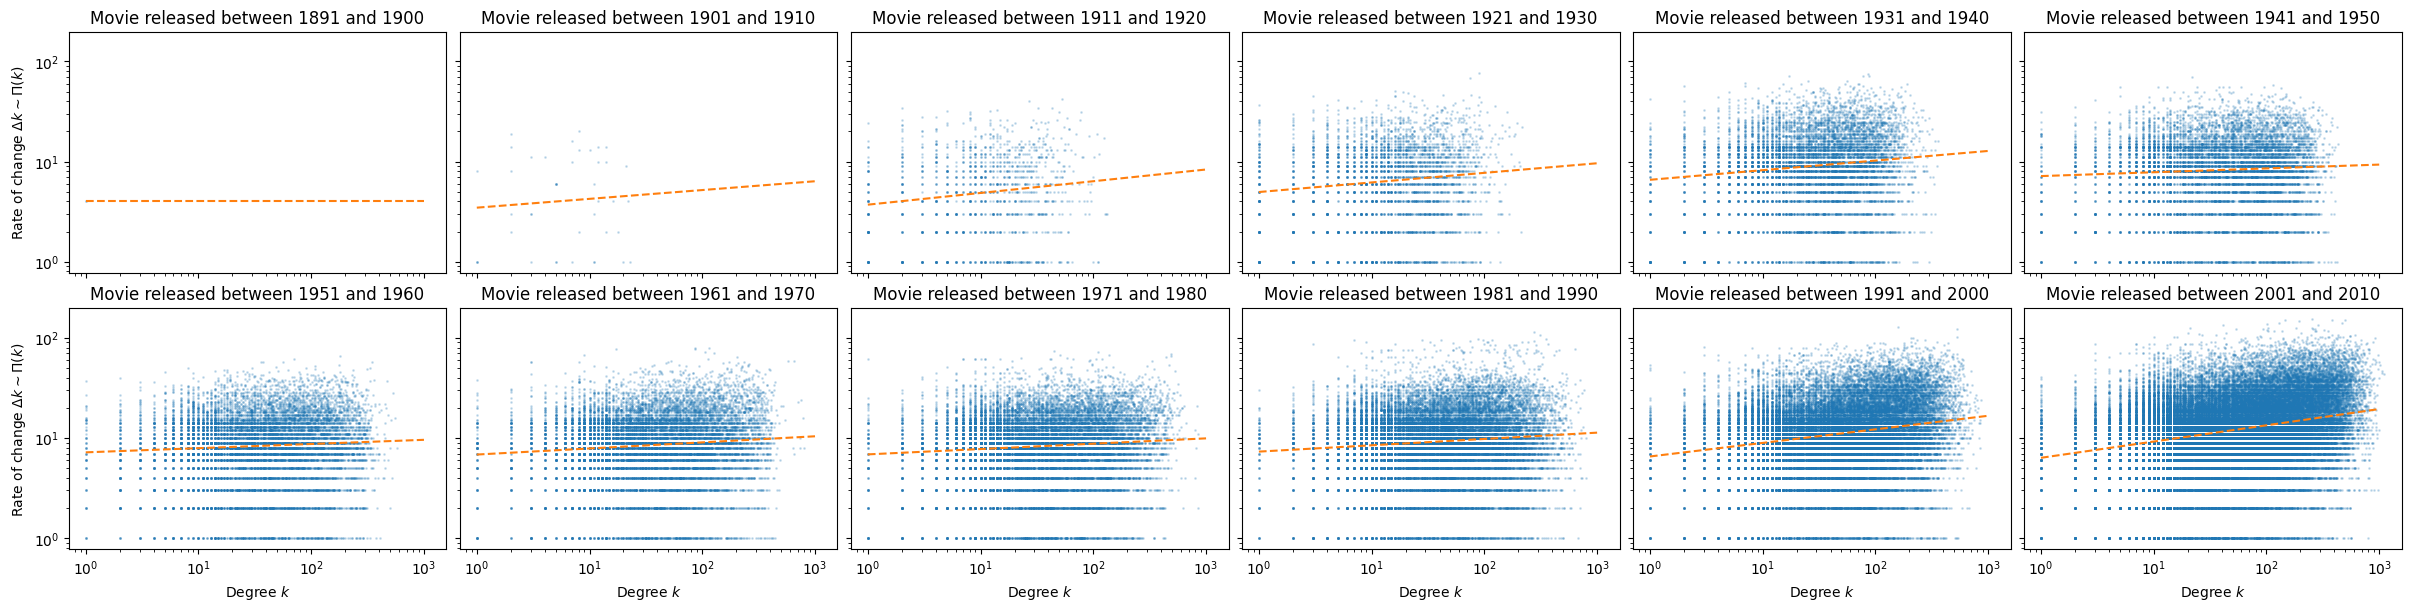

Grouping by year_qbin


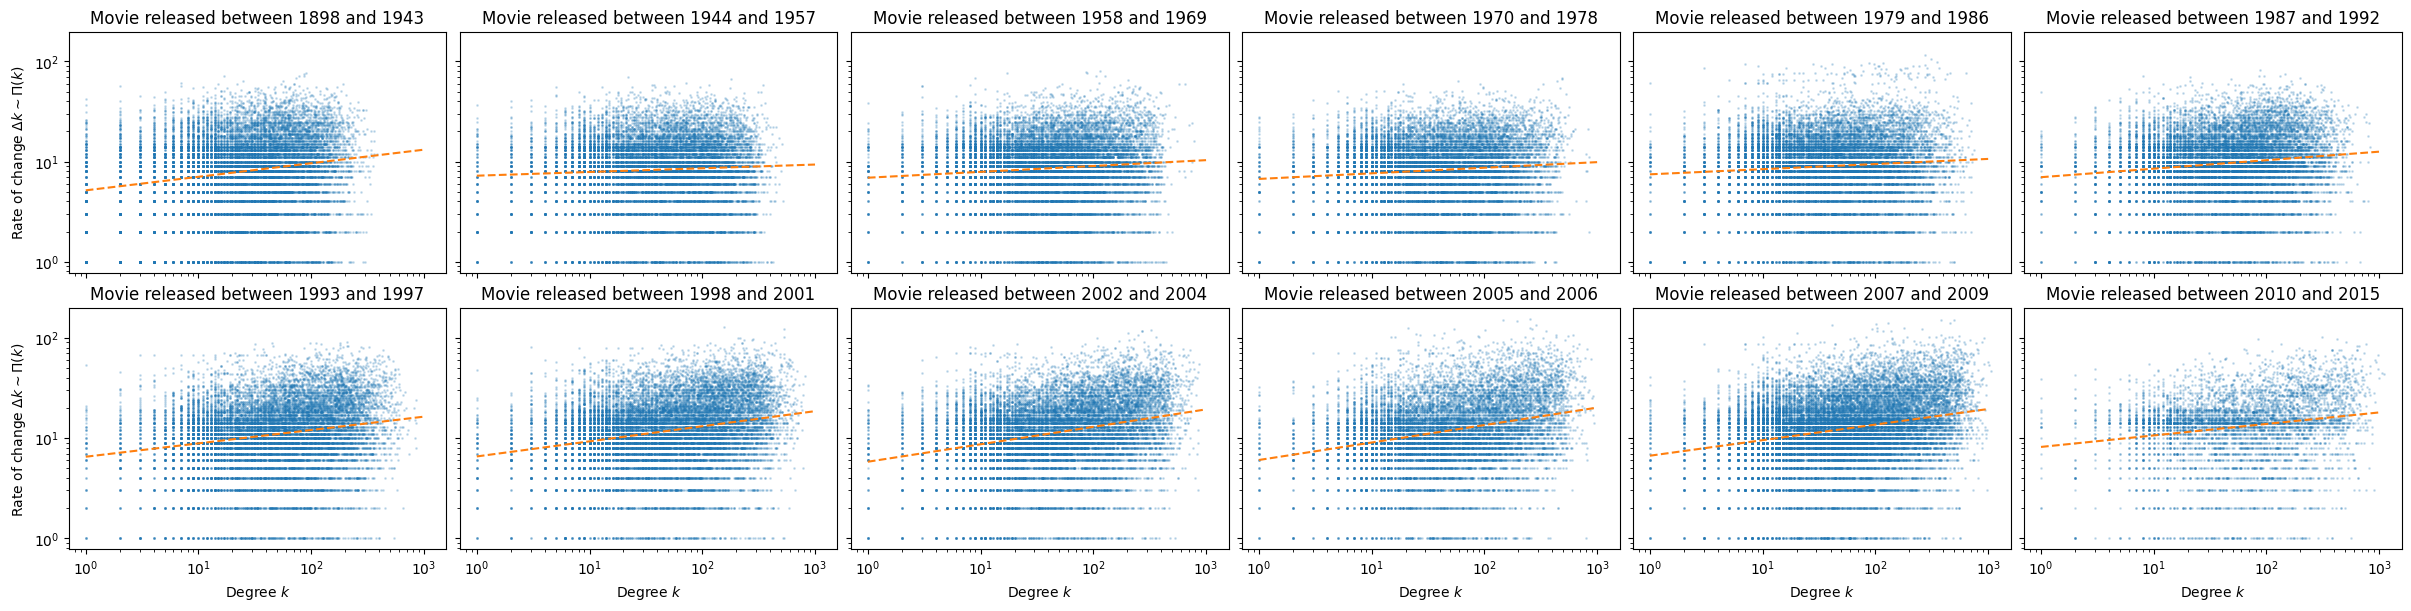

In [18]:
fitcoefs = { 'year_bin': [], 'year_qbin': [] }

for groupby_col in fitcoefs:
	print(f'Grouping by {groupby_col}')
	grid_arrangement = (6, 2)
	fig, axs = plt.subplots(
		ncols=grid_arrangement[0], nrows=grid_arrangement[1],
		figsize=(grid_arrangement[0]*4, grid_arrangement[1]*3),
		constrained_layout=True, sharex=True, sharey=True)

	for ax, (year_bin, df_pref_attachment_bin) in zip(axs.flat, df_pref_attachment.dropna().groupby(groupby_col)):
		ax.plot(df_pref_attachment_bin.degree, df_pref_attachment_bin.delta_degree, '.', markersize=2, alpha=0.2)

		model = smf.ols(formula="log_dk ~ log_k", data=dict(log_k=np.log10(df_pref_attachment_bin.degree), log_dk=np.log10(df_pref_attachment_bin.delta_degree)))
		res = model.fit()
		fitcoefs[groupby_col].append((res.params['log_k'], *res.conf_int().loc['log_k']))
		x = np.logspace(0, 3, 2)
		ax.plot(x, 10**res.predict(dict(log_k=np.log10(x))), '--')

		ax.set_xscale('log')
		ax.set_yscale('log')
		ax.set_xlabel('Degree $k$')
		ax.set_ylabel('Rate of change $\\Delta k \\sim \\Pi(k)$')
		ax.label_outer()
		ax.set_title(f'Movie released between {int(year_bin.left+1)} and {int(year_bin.right)}')

	plt.show()

Although there is no well defined trend (it is difficult to see any well defined functional form), we still see some form of preferential attachment, as $\Delta k$ seems to grow with $k$, especially for more recent movies

In [19]:
dfs_fitcoefs = { key: pd.DataFrame(values, columns=['alpha', 'ci_lower', 'ci_upper']) for key, values in fitcoefs.items() }

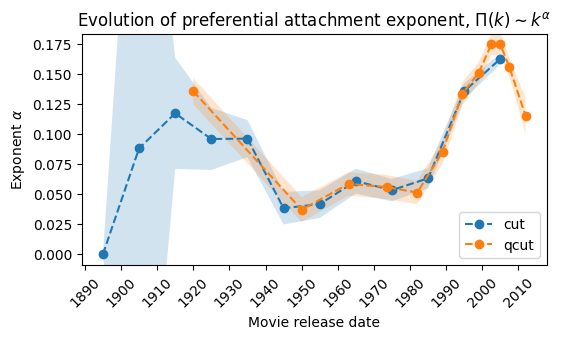

In [20]:
fig, ax = plt.subplots(figsize=(6, 3))
mid_years = df_pref_attachment.year_bin.dropna().unique().map(lambda x: (x.left + x.right)/2)
qmid_years = df_pref_attachment.year_qbin.dropna().unique().map(lambda x: (x.left + x.right)/2)

ax.plot(mid_years, dfs_fitcoefs['year_bin'].alpha, 'o--', label='cut')
ax.plot(qmid_years, dfs_fitcoefs['year_qbin'].alpha, 'o--', label='qcut')
ax.set_xticks([ int(x.left) for x in df_pref_attachment.year_bin.dropna().unique() ] + [ int(df_pref_attachment.year_bin.dropna().unique()[-1].right) ])
ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.set_xlabel('Movie release date')
ax.set_ylabel('Exponent $\\alpha$')
ax.set_title('Evolution of preferential attachment exponent, $\\Pi(k) \\sim k^{\\alpha}$')
ax.set_autoscale_on(False)
ax.fill_between(mid_years, dfs_fitcoefs['year_bin'].ci_lower, dfs_fitcoefs['year_bin'].ci_upper, alpha=0.2)
ax.fill_between(qmid_years, dfs_fitcoefs['year_qbin'].ci_lower, dfs_fitcoefs['year_qbin'].ci_upper, alpha=0.2)
ax.legend(loc='lower right')
plt.show()

cut : binning every 10 years<br>
qcut : binning 12 quartiles

### Explaining the degree

<img src="../assets/Screenshot from 2022-12-13 20-42-26.png">

In [21]:
degrees_final = degrees[:, -1].copy()
degrees_final.sort()

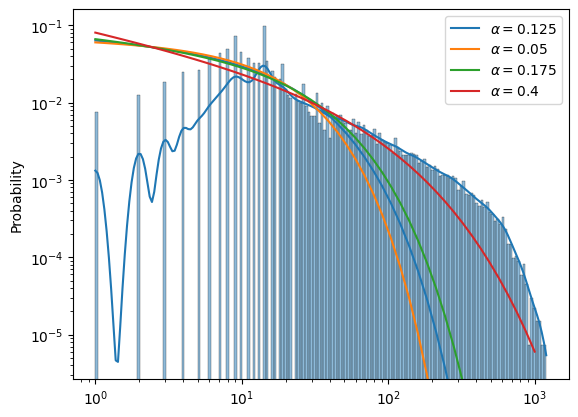

In [22]:
ax = sns.histplot(degrees_final, kde=True, log_scale=(True, True), stat='probability')
ax.set_autoscale_on(False)

k_mean = np.mean(degrees_final)
k = np.logspace(0, 3)
for alpha in [0.125, 0.050, 0.175, 0.4]:
	p_k = k**(-alpha) * np.exp(-2/(k_mean*(1-alpha)) * k**(1-alpha))
	p_k /= p_k.sum()
	ax.plot(k, p_k, label=f'$\\alpha = {alpha}$')

ax.legend()
plt.show()

In [23]:
# Problem : the cutoff is too sharp with our fits. it looks like the true alpha is larger
# maybe there is a problem with our fits ?

# Hypothesis : the A-B model does not take into account that the nodes can create further connections between them !!
# However physically, we know many existing actors continue playing together and bonding with other actors, which increases their mutual degree ! -> large tail

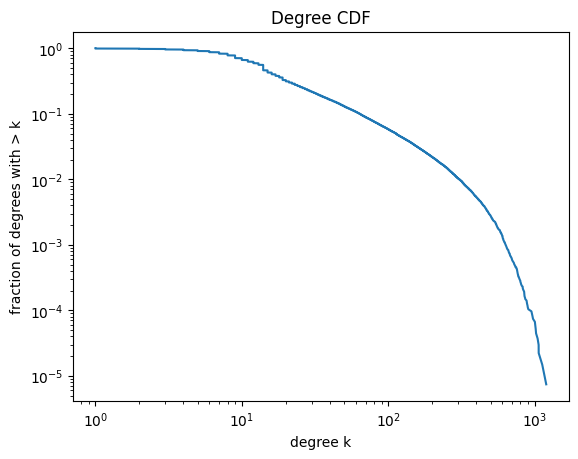

In [24]:
fig, ax = plt.subplots()
ax.plot(degrees_final, (np.arange(1, len(degrees_final)+1)/len(degrees_final))[::-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('fraction of degrees with > k')
ax.set_xlabel('degree k')
ax.set_title('Degree CDF')
plt.show()

TODO : only consider links added through arrival of new nodes, do not consider links added internally

-> but physically, we need preferential attachment to nodes that still exist ! dead actors cannot be connected to anymore, and it would bias the results

### Growth of hubs

<img src="../assets/Screenshot from 2022-12-13 21-01-28.png">

In [25]:
kmax = np.nanmax(degrees, axis=0)

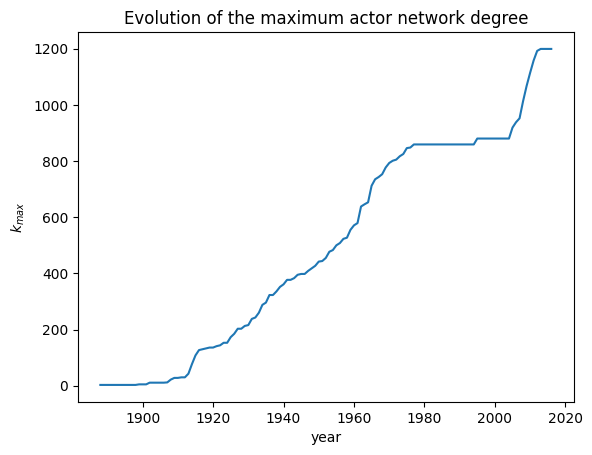

In [26]:
fig, ax = plt.subplots()
ax.plot(years, kmax)
ax.set_xlabel('year')
ax.set_ylabel('$k_{max}$')
ax.set_title('Evolution of the maximum actor network degree')
plt.show()

### Adding nodes progressively

Note : there is some amont of arbitrariness for in which order we add the actors appearing for the first time in the same movie

#### Create the pruned edgelist

In [141]:
df_newactors = pd.concat(
	# include edges i -> j and j -> i
	[df_edges, df_edges.rename(columns={'actor1_fbid': 'actor2_fbid', 'actor2_fbid': 'actor1_fbid'})],
	ignore_index=True  # WARNING : this is important, since otherwise there are duplicate indices, which fucks with the drop operation
)
df_newactors['actor1_firstmovie_year'] = (df_newactors
	.groupby('actor1_fbid')
	[['movie_release_year']]
	.min()
	.loc[df_newactors.actor1_fbid]
	.values
)
df_newactors.drop(index=df_newactors[df_newactors['actor1_firstmovie_year'] != df_newactors['movie_release_year']].index, inplace=True)
df_newactors.sort_values(['movie_release_year', 'actor1_fbid'], inplace=True)
df_newactors.reset_index(drop=True, inplace=True)

In [142]:
# we ensure we have not lost actors during the process
assert df_newactors.actor1_fbid.nunique() == uniques.nunique()
# ensure we have not included edges that happen later
assert (df_newactors.movie_release_year == df_newactors.actor1_firstmovie_year).all()

In [143]:
print(f'fraction of original edges which add a new actor to the network : {len(df_newactors)/len(df_edges):.2%}')

fraction of original edges which add a new actor to the network : 71.47%


In [144]:
df_newactors.head(20)

,actor1_fbid,actor2_fbid,movie_fbid,movie_release_year,actor1_numid,actor2_numid,actor1_firstmovie_year
0,/m/0k2pyv,/m/0k2pz6,/m/044ggd,1888,2,1,1888
1,/m/0k2pyv,/m/0k2pz0,/m/044ggd,1888,2,0,1888
2,/m/0k2pyv,/m/0k2pzd,/m/044ggd,1888,2,119615,1888
3,/m/0k2pz0,/m/0k2pz6,/m/044ggd,1888,0,1,1888
4,/m/0k2pz0,/m/0k2pzd,/m/044ggd,1888,0,119615,1888
5,/m/0k2pz0,/m/0k2pyv,/m/044ggd,1888,2,0,1888
6,/m/0k2pz6,/m/0k2pzd,/m/044ggd,1888,1,119615,1888
7,/m/0k2pz6,/m/0k2pz0,/m/044ggd,1888,0,1,1888
8,/m/0k2pz6,/m/0k2pyv,/m/044ggd,1888,2,1,1888
9,/m/0k2pzd,/m/0k2pz6,/m/044ggd,1888,1,119615,1888


#### Add nodes one by one

Since we are adding actors one by one, rather than in batches, the destination of some edges might not exist yet, and we need to prune them

In [131]:
df_newactors['actor2_exists'] = df_newactors.index.to_series().map(lambda idx: df_newactors.actor2_fbid.iat[idx] in df_newactors.actor1_fbid.iloc[:idx].values)

KeyboardInterrupt: 

In [ ]:
df_newactors.head(20)

In [ ]:
df_newactors.drop(index=df_newactors[df_newactors.actor2_exists].index, inplace=True)

adding actor /m/0k2pyv (0 new edges)


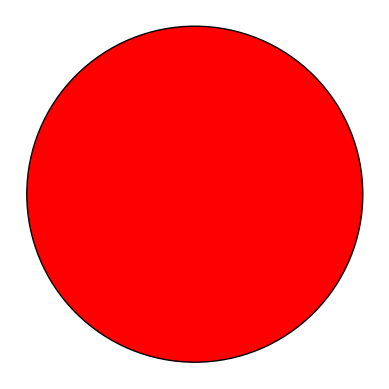

adding actor /m/0k2pz0 (1 new edges)


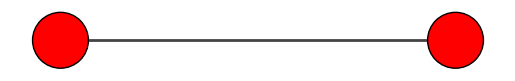

adding actor /m/0k2pz6 (2 new edges)


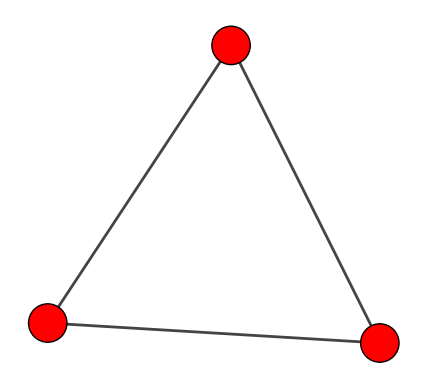

adding actor /m/0k2pzd (3 new edges)


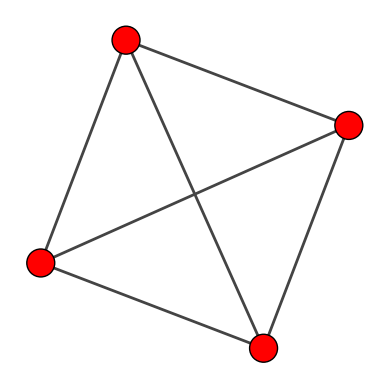

adding actor /m/0dkb48 (0 new edges)


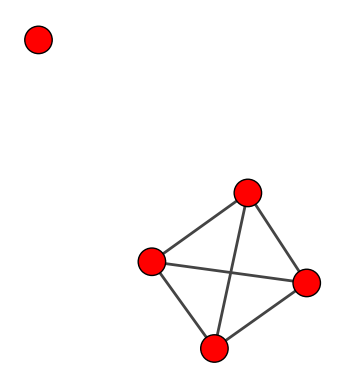

adding actor /m/0jvh17 (1 new edges)


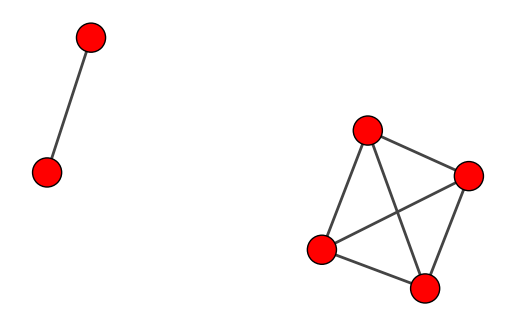

adding actor /m/02q36h4 (0 new edges)


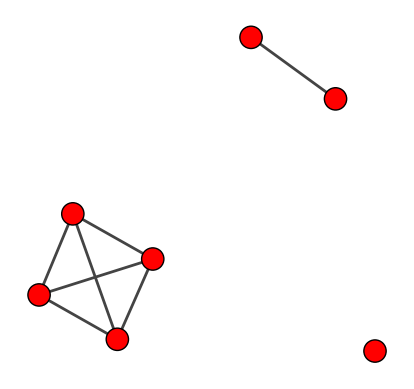

adding actor /m/03c073 (0 new edges)


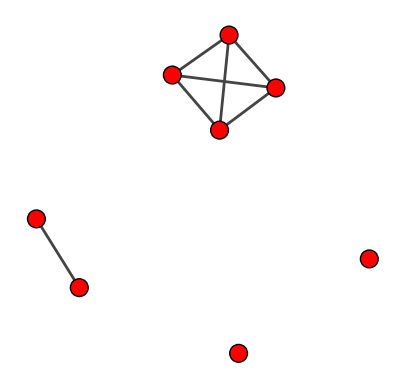

adding actor /m/041m3s (0 new edges)


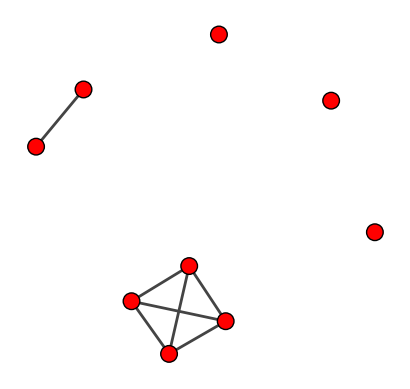

adding actor /m/091997 (1 new edges)


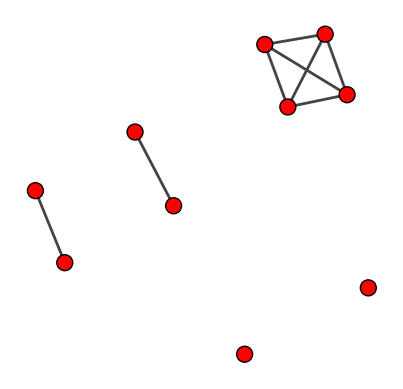

adding actor /m/0cqkn (1 new edges)


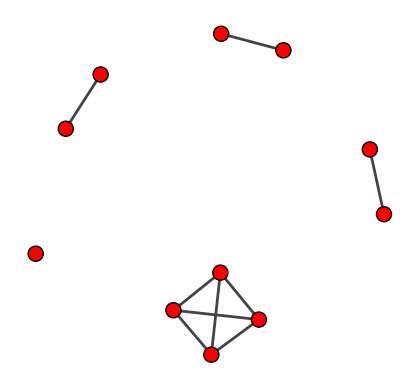

adding actor /m/0l7s_t3 (1 new edges)


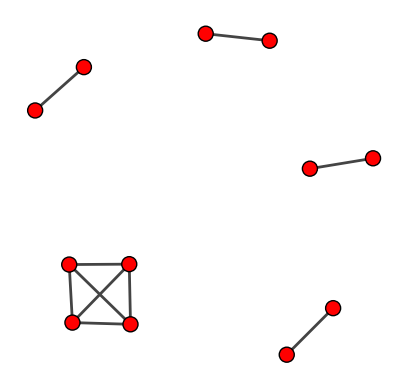

adding actor /m/0l7s_th (2 new edges)


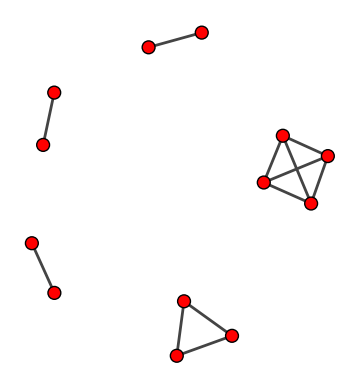

adding actor /m/0j79zjw (0 new edges)


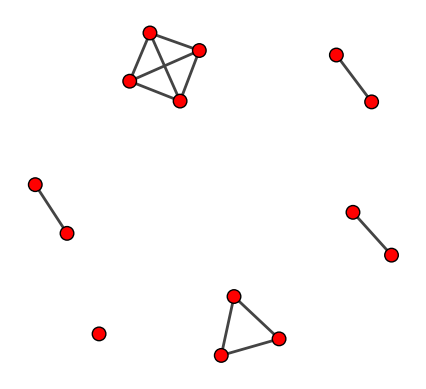

adding actor /m/0j79zk6 (1 new edges)


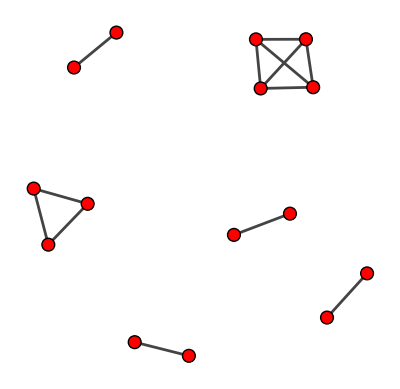

adding actor /m/01720p (0 new edges)


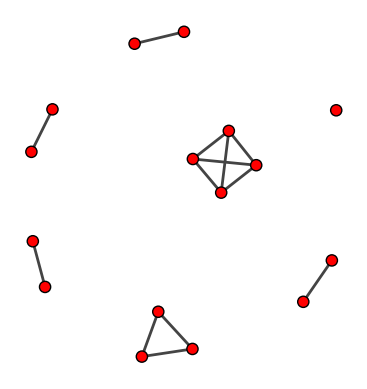

adding actor /m/0by3j (1 new edges)


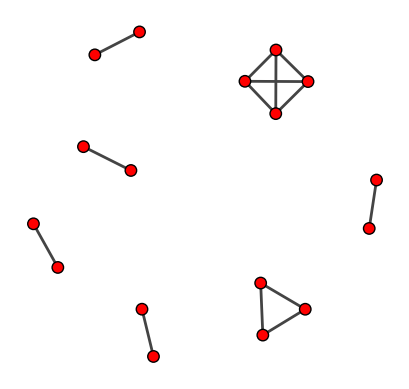

adding actor /m/03cs750 (2 new edges)


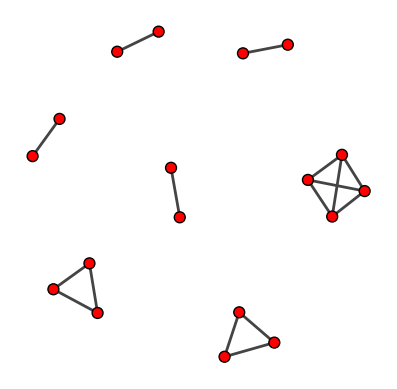

adding actor /m/0g9ckx8 (3 new edges)


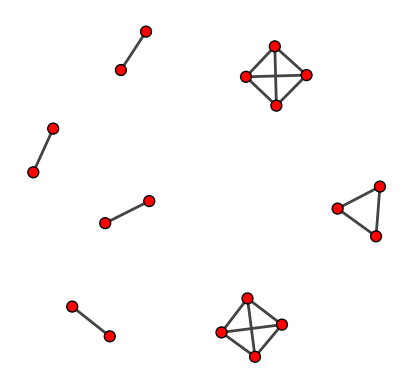

adding actor /m/0g9ckxm (4 new edges)


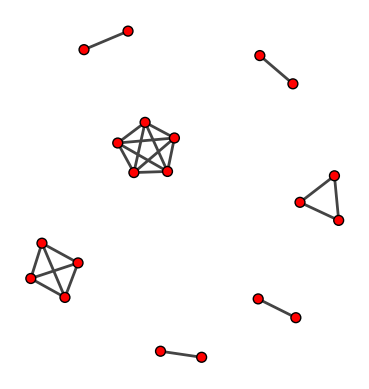

adding actor /m/0g9cky8 (5 new edges)


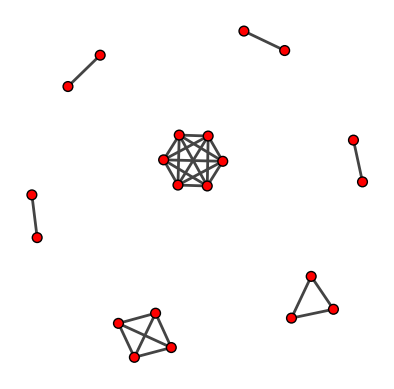

adding actor /m/0bbw6dn (0 new edges)


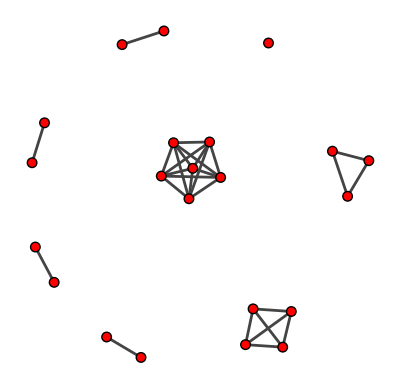

adding actor /m/0c4qt (1 new edges)


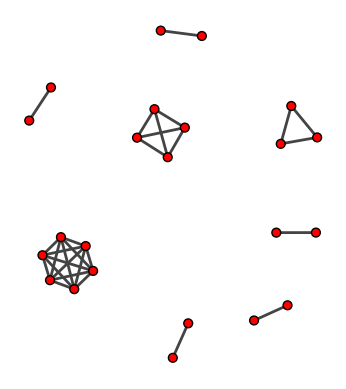

adding actor /m/0lz01ck (2 new edges)


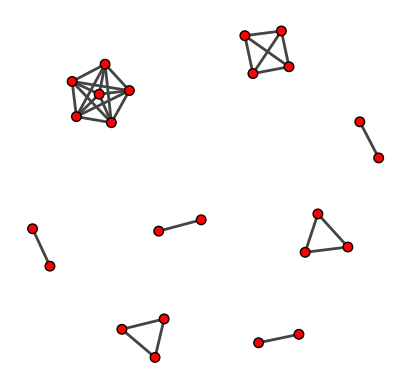

adding actor /m/03kwm5 (0 new edges)


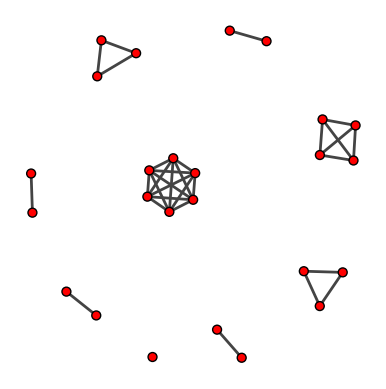

adding actor /m/07kjd71 (0 new edges)


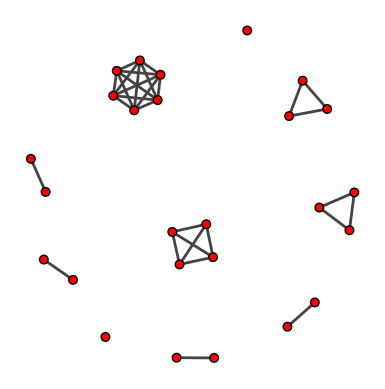

adding actor /m/083p7 (1 new edges)


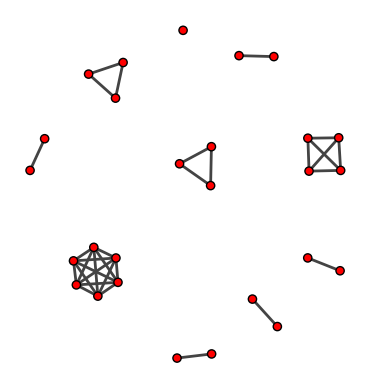

adding actor /m/0n5c_5s (1 new edges)


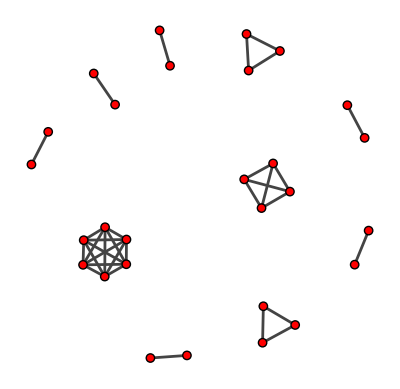

adding actor /m/02_6rwr (3 new edges)


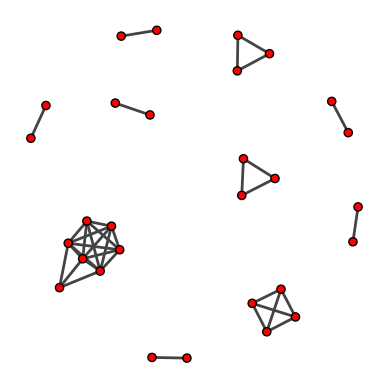

adding actor /m/02_6rxx (4 new edges)


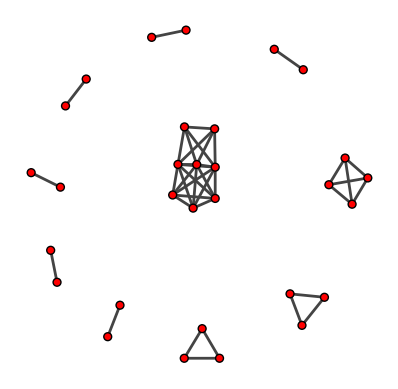

adding actor /m/0j_3xfh (5 new edges)


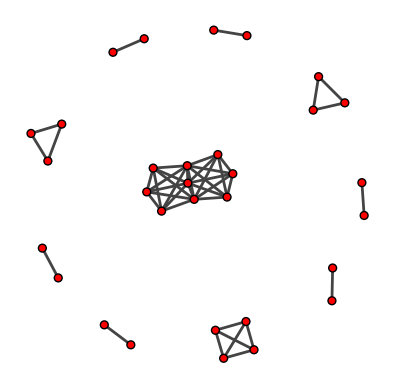

adding actor /m/0j_3xgk (6 new edges)


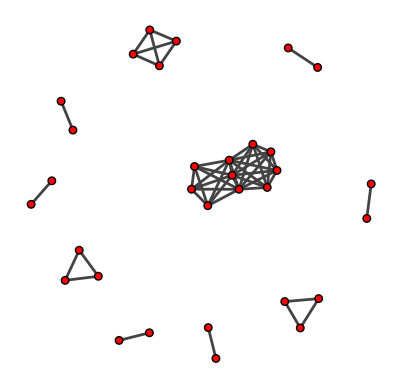

adding actor /m/0j_3xh4 (7 new edges)


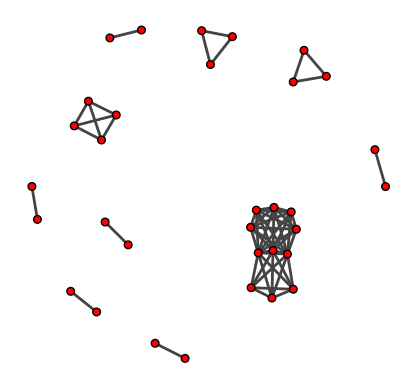

adding actor /m/0j_3xhr (2 new edges)


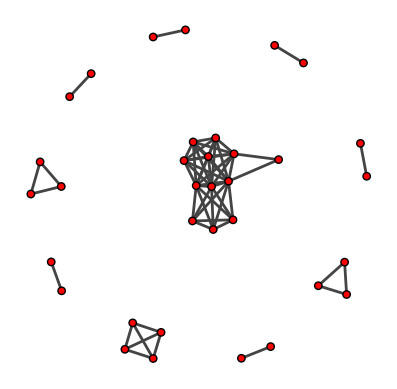

In [73]:

df_newactors_ = df_newactors.head(100).copy()

random.seed(0)  # seed the random layout

g = ig.Graph(directed=False)

def has_node(graph, name):
	try:
		graph.vs.find(name=name)
	except:
		return False
	return True

for actor_fbid, df_edges_actor in df_newactors_.groupby('actor1_fbid', sort=False):
	it = list(filter(lambda id12: has_node(g, id12[1]), zip(df_edges_actor.actor1_fbid, df_edges_actor.actor2_fbid)))
	print(f'adding actor {actor_fbid} ({len(it)} new edges)')
	g.add_vertex(actor_fbid)
	g.add_edges(it)
	fig, ax = plt.subplots()
	ig.plot(g, target=ax)
	plt.show()

#### Add actors by batches

TODO : actually we need to use the full movie date instead of the year, since an actor can star in multiple movies released the same year

So we need the first movie of the actor

In [227]:
# df_newactors_ = df_newactors.head(2000).copy()
df_newactors = df_newactors.query('movie_release_year <= 1950').copy()

g = ig.Graph(directed=True)
num_connected = []
num_movies = []
pi_k = []  # (probability, in-degree, actor_fbid, year)

for year, df_edges_year in tqdm(df_newactors.groupby('movie_release_year', sort=False)):
	new_actors = df_edges_year.actor1_fbid.unique()
	nb_new_nodes = len(new_actors)

	# compute the empirical probability of receiving a connection
	indegree_lookup = dict(zip([ v['name'] for v in g.vs ], g.indegree()))
	for old_actor in g.vs:
		actor_fbid = old_actor['name']
		nb_new_received = len(df_edges_year.query('actor2_fbid == @actor_fbid'))
		pi_k.append(( nb_new_received/nb_new_nodes, indegree_lookup[actor_fbid], actor_fbid, year ))

	g.add_vertices(new_actors)
	g.add_edges(zip(df_edges_year.actor1_fbid, df_edges_year.actor2_fbid))

	num_connected.append(len(g.connected_components()))
	num_movies.append(df_newactors.query('movie_release_year <= @year').movie_fbid.nunique())

df_pi_k = pd.DataFrame(pi_k, columns=['pi', 'kin', 'actor_fbid', 'year'])

100%|██████████| 56/56 [02:55<00:00,  3.14s/it]


In [228]:
df_pi_k.head(10)

,pi,kin,actor_fbid,year
0,0.0,3,/m/0k2pyv,1893
1,0.0,3,/m/0k2pz0,1893
2,0.0,3,/m/0k2pz6,1893
3,0.0,3,/m/0k2pzd,1893
4,0.0,3,/m/0k2pyv,1896
5,0.0,3,/m/0k2pz0,1896
6,0.0,3,/m/0k2pz6,1896
7,0.0,3,/m/0k2pzd,1896
8,0.0,1,/m/0dkb48,1896
9,0.0,1,/m/0jvh17,1896


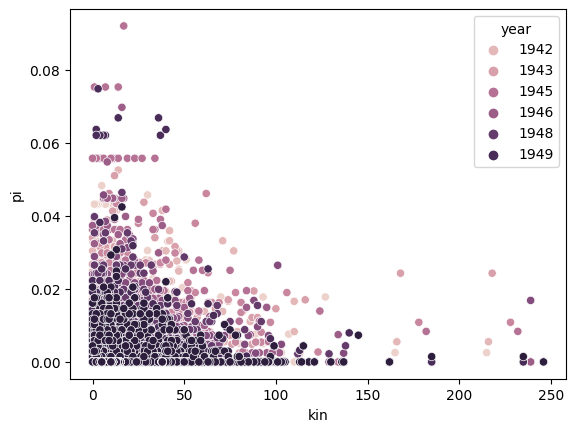

In [234]:
ax = sns.scatterplot(df_pi_k.query('year > 1940'), x='kin', y='pi', hue='year')

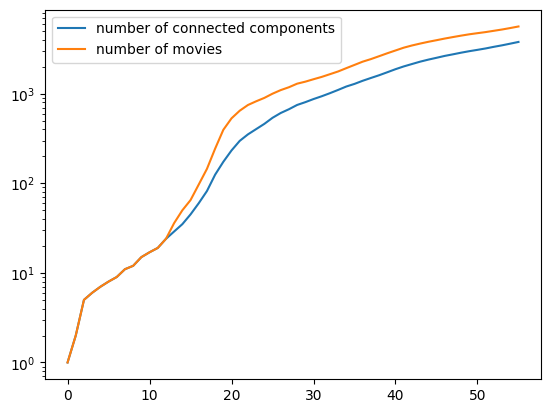

In [233]:
# at the start, every movie adds a new unique component, then the clusters start to appear !
fig, ax = plt.subplots()
ax.plot(num_connected, label='number of connected components')
ax.plot(num_movies, label='number of movies')
ax.set_yscale('log')
ax.legend()
plt.show()